# First step is to import the data. Additionally, let's import all of the libraries we need. 

In [1]:
import pandas as pd
import csv
import time
import functools as ft
import matplotlib.pyplot as plt
import seaborn as sns
# This is to ignore depreciation warnings. Not recommended for actual projects
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "rtings_data.csv"
data = pd.read_csv(path)

# Next, we need to clean all the data. 
Some fields that need to be removed are stored in bad_columns. We drop these. 
Then we replace all instances of "No" with False and "Yes with True. 

In [3]:
bad_columns = ["product_price_href", "web-scraper-order", "web-scraper-start-url", "price_text_button", "test_methodology_version", "ios_support", "android_support", "os_compatibility"]
to_remove = [column for column in bad_columns if column in data.columns]
data = data.drop(columns=to_remove)

data = data.replace("No", False)
data = data.replace("Yes", True)

print(data.shape)

(289, 29)


This lists all the brands of headphones we collected. 

In [4]:
brands = data["brand_name"].unique()
print(brands)
print(len(brands))

['Sony' 'Razer' 'EPOS' 'Bose' 'Astro' 'Sennheiser' 'Anker' 'Logitech'
 'HyperX' 'SteelSeries' 'Apple' 'Google' 'JBL' 'EarFun' 'Samsung'
 'Bowers & Wilkins' 'Jabra' 'Devialet' 'Raycon' 'Bang & Olufsen' 'Focal'
 'Audeze' 'Beats' 'Shure' 'Wyze' 'Skullcandy' 'TOZO' 'Xbox' 'Corsair'
 'Amazon' 'Nothing' 'Shokz' 'Denon' 'Jaybird' 'Dyson' 'JLab Audio'
 'Turtle Beach' 'OnePlus' 'Status' 'Audio-Technica' 'AfterShokz' 'AKG'
 'Avantree' 'Insignia' 'TREBLAB' 'Ultimate Ears' 'FIIL' 'Cowin'
 'Plantronics' 'Mpow' 'Creative' 'TaoTronics' 'SoundPeats' 'ROCCAT'
 'Klipsch' 'Cambridge Audio' 'Drop']
57


# Here is where we compile all the operating system support (cross-compatibility). 
Here, I take windows and macOS support and then OR it with bluetooth rating being greater than 0. 
I also print out all of the headphones that only have one operating system being supported. 
Notice that all of the headphones are targetted towards gaming, so they likely use dongles. 

In [5]:
os_support = pd.DataFrame()
os_support["product_name"] = data["product_name"]
# If bluetooth rating is > 0, there is bluetooth support. Bluetooth support is universal
os_support["windows"] = data["windows_support"]|(data["bluetooth_rating"]>0)
os_support["macos"] = data["macos_support"]|(data["bluetooth_rating"]>0)
os_support["universal"] = os_support["macos"]&os_support["windows"]
os_support["bluetooth"] = data["bluetooth_rating"]>0
# Analysis
print("There are {} headphones with Windows support. ".format(os_support.windows.value_counts()[True]))
print("There are {} headphones with macOS support. ".format(os_support.macos.value_counts()[True]))
for index, row in os_support.iterrows():
    if row["windows"] and not row["macos"]:
        print("{} only supports Windows. ".format(row["product_name"]))
    elif row["macos"] and not row["windows"]:
        print("{} only supports Windows. ".format(row["product_name"]))

There are 283 headphones with Windows support. 
There are 275 headphones with macOS support. 
HyperX Cloud III Wireless only supports Windows. 
HyperX Cloud Alpha Wireless only supports Windows. 
HyperX Cloud 2/Cloud II Wireless only supports Windows. 
Razer Kraken V3 Pro Wireless only supports Windows. 
HyperX Cloud Flight only supports Windows. 
ROCCAT Elo 7.1 Air Wireless only supports Windows. 
HyperX Cloud Flight S only supports Windows. 
Razer Nari Ultimate Wireless only supports Windows. 


# We determine sound quality at this stage. 
We multiply all of the values (out of 10) together.
Then we divide by max to get a score out of 1. 

In [6]:
# Normalized sound quality score using two scores out of 10
sound_quality = pd.DataFrame()
sq = sound_quality
sq["product_name"] = data["product_name"]
sq["frc"] = data["frequency_response_consistency"]
sq["pd"] = data["peaks_dips"]
sq["neutral"] = data["neutral_sound"]

sq["sound_quality"] = sq["pd"]*sq["frc"]*sq["neutral"]
sq["sound_quality"] = sq["sound_quality"]/max(sq["sound_quality"])
sq = sq.sort_values(by=["sound_quality"], ascending=False)
sq.head()



,product_name,frc,pd,neutral,sound_quality
130,Samsung Galaxy Buds+ Truly Wireless,9.6,8.7,7.9,1.000000
52,Jabra Elite 7 Active True Wireless,9.5,9.1,7.6,0.995775
46,Jabra Elite 7 Pro True Wireless,9.1,9.0,7.8,0.968191
282,TaoTronics SoundLiberty 79 Truly Wireless,9.9,8.7,7.4,0.965981
200,JBL LIVE 300TWS Truly Wireless,9.9,8.6,7.3,0.941974


Here is an insight into latency between devices. 

In [7]:
latency = pd.DataFrame()
latency["product_name"] = data["product_name"]
latency["aptx"] = data["latency_aptx"].str.split(" ms", n=1, expand=True)[0].astype(float)
latency["sbc"] = data["latency_sbc"].str.split(" ms", n=1, expand=True)[0].astype(float)

latency["avg"] = (latency["aptx"]+latency["sbc"])/2
latency.head()
latency = latency.sort_values(by=["avg"])
top_5 = latency.head()
print("Top 5 lowest latency devices:")
for idx, i in top_5.iterrows():
    print(str(idx+1)+ ". ", i["product_name"], i["avg"], " ms")
latency["l_score"] = 1-(latency["avg"]-min(latency["avg"]))/max(latency["avg"])
latency.sort_values(by=["l_score"], ascending=False).head()

Top 5 lowest latency devices:
4.  EPOS GTW 270 Hybrid Truly Wireless 104.0  ms
229.  Sennheiser HD 4.40 BT Wireless 124.5  ms
187.  Sennheiser PXC 550-II Wireless 133.5  ms
241.  Sony WH-CH700N Wireless 169.0  ms
50.  Shure AONIC 50 Wireless 173.5  ms


,product_name,aptx,sbc,avg,l_score
3,EPOS GTW 270 Hybrid Truly Wireless,108.0,100.0,104.0,1.000000
228,Sennheiser HD 4.40 BT Wireless,118.0,131.0,124.5,0.945114
186,Sennheiser PXC 550-II Wireless,103.0,164.0,133.5,0.921017
240,Sony WH-CH700N Wireless,156.0,182.0,169.0,0.825971
49,Shure AONIC 50 Wireless,171.0,176.0,173.5,0.813922


# We calculate an age score below. 
We assign bluetooth codec version to an integer and then map the version to our value. 
We also get the age of our product and then combine them into a score out of 1. 
See how Apple products compare to other options below.

In [8]:
age = pd.DataFrame()
bluetooth_map = {
    "No Bluetooth": 0,
    "Unspecified": 0,
    "4.0": 1,
    "4.1": 2,
    "4.2": 3,
    "4.2 + W1 chip": 3,
    "5.0": 4,
    "5.0+H1 chip": 4,
    "5.0+W1 chip": 4,
    "5.010": 5,
    "5.1": 6,
    "5.2": 7, 
    "5.3": 8,
    "5.3+H2 chip": 8,
}
age["product_name"] = data["product_name"]
age["brand_name"] = data["brand_name"]
age["bluetooth"] = data["bluetooth_version"]
age["year"] = (2023-data["release_year"])**2
age["bluetooth"] = age["bluetooth"].map(bluetooth_map)

age.head()
age["year"] = (max(age["year"])-age["year"])/max(age["year"])
age["bluetooth"] = age["bluetooth"]/max(age["bluetooth"])
age["age_score"] = age["year"]*age["bluetooth"]
age["age_score"] = age["age_score"]/max(age["age_score"])
age.sort_values(by=["age_score"], ascending=False).head()


age[age["brand_name"]=="Apple"].head()



,product_name,brand_name,bluetooth,year,age_score
16,Apple AirPods Pro (2nd generation) Truly Wireless,Apple,1.0,0.984375,0.984375
61,Apple AirPods Max Wireless,Apple,0.5,0.859375,0.429688
68,Apple AirPods (3rd generation) Truly Wireless,Apple,0.5,0.937500,0.468750
90,Apple AirPods Pro Truly Wireless,Apple,0.5,0.750000,0.375000
170,Apple AirPods (2nd generation) Truly Wireless,Apple,0.5,0.750000,0.375000


In [9]:
age.sort_values(by=["age_score"], ascending=False).head()

,product_name,brand_name,bluetooth,year,age_score
25,Sony WF-1000XM5 Truly Wireless,Sony,1.0,1.0,1.0
13,Bose QuietComfort Ultra Earbuds Truly Wireless,Bose,1.0,1.0,1.0
29,Bose QuietComfort Ultra Headphones Wireless,Bose,1.0,1.0,1.0
56,Anker Soundcore Space One Wireless,Anker,1.0,1.0,1.0
120,Nothing Ear (2) Truly Wireless,Nothing,1.0,1.0,1.0


# We get app support score here. 
It is the score out of 10, so divide by max. 
We can see Apple comparisons below. 

In [10]:
sp = pd.DataFrame()
sp["product_name"] = data["product_name"]
sp["brand_name"] = data["brand_name"]
sp["app"] = data["app_support"]
sp["app"] = sp["app"]/max(sp["app"])

In [11]:
bq = pd.DataFrame()
bq["product_name"] = data["product_name"]
bq["brand_name"] = data["brand_name"]
bq["build_quality"] = data["build_quality"] * data["battery"]
bq["build_quality"] = bq["build_quality"]/max(bq["build_quality"])
bq.sort_values(by=["build_quality"], ascending=False).head()

,product_name,brand_name,build_quality
12,Logitech G PRO X 2 LIGHTSPEED Wireless,Logitech,1.000000
10,Sennheiser MOMENTUM 4 Wireless,Sennheiser,0.979381
113,SteelSeries Arctis 7+ Wireless,SteelSeries,0.958763
195,SteelSeries Arctis 7P+ Wireless,SteelSeries,0.958763
168,Razer Opus Wireless 2021,Razer,0.948454


In [12]:
sp[sp["brand_name"]=="Apple"].head()

,product_name,brand_name,app
16,Apple AirPods Pro (2nd generation) Truly Wireless,Apple,0.722222
61,Apple AirPods Max Wireless,Apple,0.666667
68,Apple AirPods (3rd generation) Truly Wireless,Apple,0.555556
90,Apple AirPods Pro Truly Wireless,Apple,0.611111
170,Apple AirPods (2nd generation) Truly Wireless,Apple,0.555556


# Finally, we combine everything into a longevity score. 
We start by merging all dataframes together. 

In [13]:
metrics = [sq, bq, age, sp]

longevity = ft.reduce(lambda left, right: pd.merge(left, right, on="product_name"), metrics)
l = longevity
"""
runs = 0
for sq in range(1,2):
    # print(sq,5)
    for bq in range(1,2):
        for age in range(1,2):
            for sp in range(1,2):
                # runs += 1
                # weights["sq"] = sq
                # weights["bq"] = bq
                # weights["age"] = age
                # weights["sp"] = sp
                
                # winners["wins"] += w["bq"]*l["build_quality"]+w["sq"]*l["sound_quality"]+w["age"]*l["age_score"]+w["sp"]*l["app"]
                winners["sq"] += w["sq"] * sq * l["sound_quality"]
                winners["bq"] += w["bq"] * bq * l["build_quality"]
                winners["age"] += w["age"] * age * l["age_score"]
                winners["sp"] += sp * w["sp"] * l["app"]"""


'\nruns = 0\nfor sq in range(1,2):\n    # print(sq,5)\n    for bq in range(1,2):\n        for age in range(1,2):\n            for sp in range(1,2):\n                # runs += 1\n                # weights["sq"] = sq\n                # weights["bq"] = bq\n                # weights["age"] = age\n                # weights["sp"] = sp\n                \n                # winners["wins"] += w["bq"]*l["build_quality"]+w["sq"]*l["sound_quality"]+w["age"]*l["age_score"]+w["sp"]*l["app"]\n                winners["sq"] += w["sq"] * sq * l["sound_quality"]\n                winners["bq"] += w["bq"] * bq * l["build_quality"]\n                winners["age"] += w["age"] * age * l["age_score"]\n                winners["sp"] += sp * w["sp"] * l["app"]'

# Next, we establish weights for each category before calculating vector distance from origin. 
This will assign the most well-rounded headphones with the highest scores. 
See Apple comparisons below. 

In [14]:
weights = {
    "sq": 13,
    "bq": 12,
    "age":9,
    "sp": 2,
}
w = weights
winners = pd.DataFrame()
winners["product"] = l["product_name"]
winners["brand"] = l["brand_name"]
winners["sq"] = w["sq"] * l["sound_quality"]
winners["bq"] = w["bq"] * l["build_quality"]
winners["age"] = w["age"] * l["age_score"]
winners["sp"] = w["sp"] * l["app"]

winners["score"] = (winners["sq"]**2 + winners["bq"]**2 + winners["age"]**2 + winners["sp"]**2)**0.5
# winners["sq"]**power + winners["bq"]**power + winners["age"]**power + winners["sp"]**power
winners["sq"] /= max(winners["sq"])
winners["bq"] /= max(winners["bq"])
winners["age"] /= max(winners["age"])
winners["sp"] /= max(winners["sp"])

#out = l[["product_name","score", "build_quality", "sound_quality", "age_score", "app"]]
#out = out.sort_values(by=["score"], ascending=False)
winners = winners.sort_values(by=["score"], ascending=False)
winners["score"]/=max(winners["score"])
winners.head()

,product,brand,sq,bq,age,sp,score
1,Jabra Elite 7 Active True Wireless,Jabra,0.995775,0.724871,0.820312,0.888889,1.000000
2,Jabra Elite 7 Pro True Wireless,Jabra,0.968191,0.744201,0.820312,0.888889,0.991546
30,Apple AirPods Pro (2nd generation) Truly Wireless,Apple,0.844855,0.721649,0.984375,0.722222,0.958063
9,JBL TUNE 230NC TWS True Wireless,JBL,0.898352,0.753866,0.820312,0.888889,0.957538
12,Nothing Ear (2) Truly Wireless,Nothing,0.887986,0.639175,1.000000,0.833333,0.957495


In [15]:
winners[winners["brand"]=="Apple"].head()
print((0.958063+0.778570+0.707872)/3)

0.814835


In [16]:
winners[winners["product"]=="Sony WH-1000XM5 Wireless"].head()

,product,brand,sq,bq,age,sp,score
115,Sony WH-1000XM5 Wireless,Sony,0.672681,0.821521,0.861328,0.888889,0.887316


In [17]:
winners["product_name"] = winners["product"]
final_data = pd.merge(data, winners, on="product_name")
final_data = final_data.sort_values(by=["score"], ascending=False)
print(final_data)

                                          product_name test_methodology  \
52                  Jabra Elite 7 Active True Wireless             v1.5   
46                     Jabra Elite 7 Pro True Wireless             v1.5   
16   Apple AirPods Pro (2nd generation) Truly Wireless             v1.6   
123                   JBL TUNE 230NC TWS True Wireless             v1.5   
120                     Nothing Ear (2) Truly Wireless             v1.5   
..                                                 ...              ...   
288                      JBL Tune 225TWS True Wireless             v1.5   
254                       Razer Nari Ultimate Wireless             v1.5   
178               Insignia Digital Wireless Headphones             v1.5   
135                   Status Between Pro True Wireless             v1.5   
230                      OnePlus Buds Z Truly Wireless             v1.5   

         price                                         price-href  \
52   SEE PRICE  http://www.ama

In [18]:
if False:
    for idx, row in final_data.iterrows():
        print("{}\t\tScore: {}".format(row["product"],row["score"]))

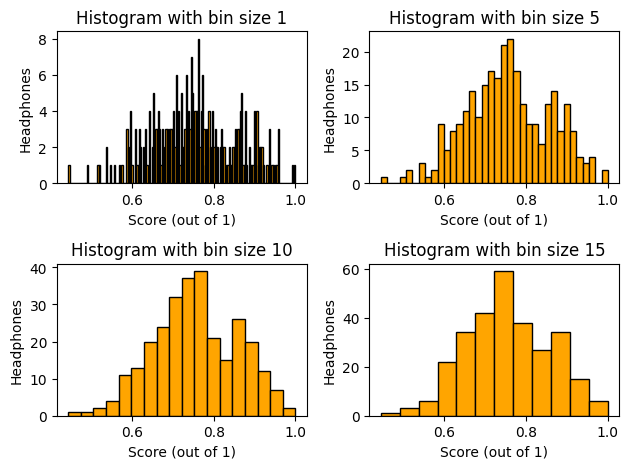

In [22]:
for i, width in enumerate([1, 5, 10, 15]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(winners['score'], bins = int(180/width),
             color = 'orange', edgecolor = 'black')
    
    # Title and labels
    plt.title('Histogram with bin size {}'.format(width))
    plt.xlabel('Score (out of 1)')
    plt.ylabel('Headphones')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Headphones')

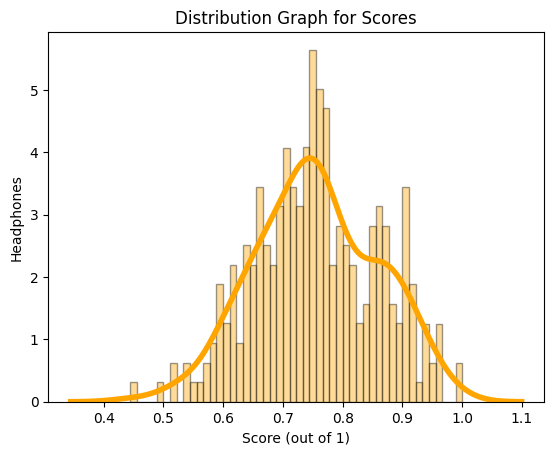

In [20]:
sns.distplot(winners['score'], hist=True, kde=True, 
             bins=int(50), color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('Distribution Graph for Scores')
plt.xlabel('Score (out of 1)')
plt.ylabel('Headphones')

In [21]:
count = winners.groupby(by=["brand"])["score"].count()
mean = winners.groupby(by=["brand"])["score"].mean()
average = winners["score"].mean()
brands = pd.merge(count, mean, on="brand")
#print(brands.sort_values(by=["score_x", "score_y"], ascending=False))
# brands["optimized"] = ((brands["score_x"]/max(brands["score_x"]))**2+(brands["score_y"])**2)**(1/2)
limited = brands[brands["score_y"]>average]
limited = limited[limited["score_x"]>4]

print(limited.sort_values(by=["score_y"], ascending=False))


                  score_x   score_y
brand                              
Jabra                  16  0.840316
Bose                   14  0.820126
Samsung                 6  0.802261
JBL                    27  0.790893
Apple                   5  0.782186
Bowers & Wilkins        5  0.782040
Sennheiser             11  0.780333
Anker                  16  0.774613
Sony                   31  0.759414
